# CHIDO modelling and retrieval example

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack, trim_stack
from pyPSFstack.diversities import ZDiversity, PDiversity
from pyPSFstack.cost_functions import CostGaussian

## Modelling a PSF stack

Let us begin by specifying the experimental parameters:

In [2]:
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
distance_coverslip = 30
wavelength = 525

These parameters, in turn, fix the pupil properties:

In [3]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = 128

Then we define the pupil sequence that we want to model. In general this will be composed by a source and a window at the Fourier plane. 

In [7]:
params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf

params['window'] = {}
params['window']['c'] = 1.24*np.pi

In [8]:
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
wdw = SEO(**params['pupil'],**params['window'])
pupil_sequence = [src, wdw]

Then we define the phase and polarization diversities:

In [9]:
params['zdiversity'] = {}
zi = -300; zf = 300; z_step = 100
params['zdiversity']['z_list'] = np.arange(zi,zf+z_step,z_step) / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/4
params['pdiversity']['pol_analyzer'] = 'quarter2pol'
params['pdiversity']['angle_list'] = np.arange(angle_i,angle_f+angle_step,angle_step)

In [10]:
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
pdiv = PDiversity(**params['pdiversity'])

Finally, we initialize an instance of the class `PSFStack` which allows us to compute the desired PSF stack and even model the effect of background, photobleaching and noise:

In [11]:
psfs = PSFStack(pupils=pupil_sequence,zdiversity=zdiv,pdiversity=pdiv)
psfs.compute_psf_stack()

Let us visualize the result:

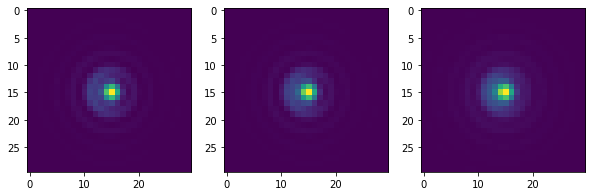

In [15]:
pdiv_ind = 0
zdiv_mid_ind = int((zf-zi)/z_step//2)
trimmed_stack = trim_stack(psfs.psf_stack, 30)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for ind in range(3):
    ax[ind].imshow(trimmed_stack[...,zdiv_mid_ind-1+ind,pdiv_ind])


Now, we can model the effect of background illumination and noise. This is defined in terms of the maximum number of photons at a given pixel for the whole stack:

In [13]:
modelled_stack = psfs.model_experimental_stack(bckgd_photons=30,N_photons=1000,N_pts=30)

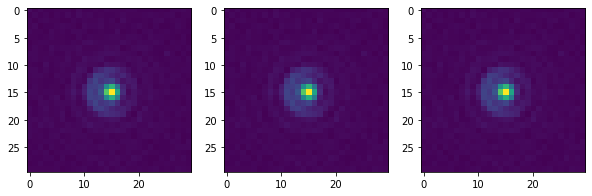

In [14]:
pdiv_ind = 0
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for ind in range(3):
    ax[ind].imshow(modelled_stack[...,zdiv_mid_ind-1,pdiv_ind])

## Birefringent pupil retrieval

Using the previous modelled stack as if it were experimental data, we can demonstrate how to retrieve the birefringent window placed in the Fourier plane: 

In [16]:
params['aberrations'] = {}
params['aberrations']['jmax_list'] = [10]*5
params['aberrations']['index_convention'] = 'fringe'

After creating the different components of the pupil we need to activate which pupil parameters we want to optimize. Here, we only consider thos of the aberration mask:

In [40]:
src_ret = DipoleInterfaceSource(**params['pupil'],**params['source'])
abe = UnitaryAberrations(**params['pupil'],**params['aberrations'])
abe.activate_parameters_optimization()
pupil_sequence = [src_ret, abe]

Now, we initialize our instance of the `PSFStack` class and visualize the modelled psfs.

In [41]:
psfs_ret = PSFStack(pupils=pupil_sequence,zdiversity=zdiv,pdiversity=pdiv)
psfs_ret.compute_psf_stack()

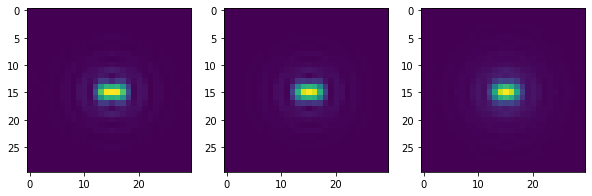

In [42]:
pdiv_ind = 0
zdiv_mid_ind = int((zf-zi)/z_step//2)
trimmed_stack = trim_stack(psfs_ret.psf_stack, 30)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for ind in range(3):
    ax[ind].imshow(trimmed_stack[...,zdiv_mid_ind-1+ind,pdiv_ind])


We load the stack that will serve as the measured data:

In [43]:
psfs_ret.set_data_psf_stack(modelled_stack)

Then we choose the cost function

In [44]:
psfs_ret.set_cost_function(CostGaussian())

Finally, we launch the optimization

In [45]:
opt_res = psfs_ret.optimize_parameters(maxiter=500)

We visualize the results, first the evolution of the cost function, then the retrieved pupil and the corresonding psf

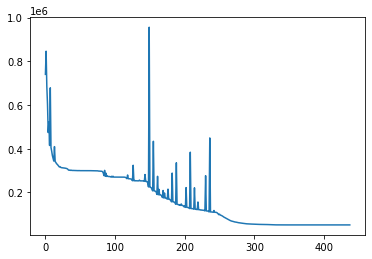

In [46]:
plt.plot(psfs_ret.cost_evol[2:])

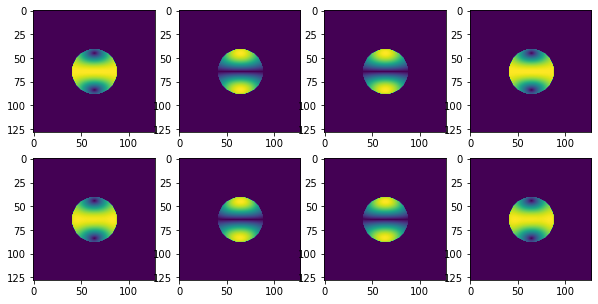

In [47]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
for inx in range(2):
    for iny in range(2):
        ax[0,inx+2*iny].imshow(np.abs(psfs.pupils[1].pupil_array[...,inx,iny]))
        ax[1,inx+2*iny].imshow(np.abs(psfs_ret.pupils[1].pupil_array[...,inx,iny]))

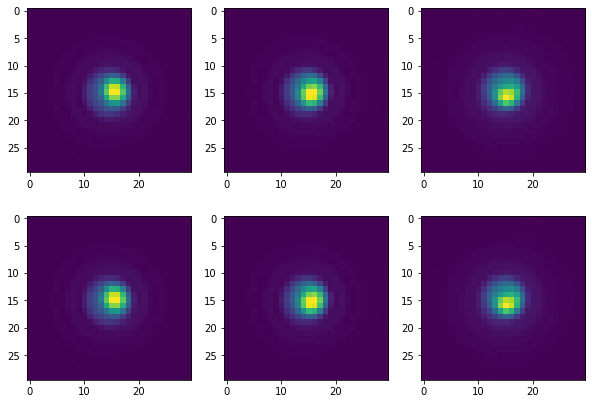

In [48]:
pdiv_ind = 1
zdiv_mid_ind = int((zf-zi)/z_step//2)
trimmed_stack = trim_stack(psfs.psf_stack, 30)
ret_trimmed_stack = trim_stack(psfs_ret.psf_stack, 30)
fig, ax = plt.subplots(2,3,figsize=(10,7))
for ind in range(3):
    ax[0,ind].imshow(trimmed_stack[...,zdiv_mid_ind-1+ind,pdiv_ind])
    ax[1,ind].imshow(ret_trimmed_stack[...,zdiv_mid_ind-1+ind,pdiv_ind])